# HW 3 - Synonym Detection In Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning.

This will be your first assignment working in Spark. You'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:  
* ... __define__ the terms `one-hot encoding`, `co-occurrance matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 


__`NOTE`__: your reading assignment for weeks 5 and 6 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings -- they are directly relevant to this assignment.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
# Spark configuration Information (RUN THIS CELL AS IS)
sc.getConf().getAll()

[('spark.app.name', 'hw3_notebook'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '42763'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261'),
 ('spark.app.id', 'local-1560395862774')]

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. Feel free to answer each one very briefly.

### Q1 Tasks:

* __a) short response:__ What is Spark? How  does it relate to Hadoop MapReduce?

* __b) short response:__ In what ways does Spark follow the principles of statelessness (a.k.a. functional programming)? List at least one way in which it allows the programmer to depart from this principle. 

* __c) short response:__ In the context of Spark what is a 'DAG' and how do they relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?


* __d) short response:__ Give a specific example of when we would want to `cache()` an RDD and explain why.

* __e) environment:__ List your environment configuration in which you will be working for this assignment, including OS, Number of Cores, CPUs, Memory. Are you using Docker? Are you running in the cloud (what is your cloud Spark configuration)? (If you are working on a Mac, you can use the these commands to get the system configuration: `sw_vers` and `system_profiler SPHardwareDataType`).

### Q1 Student Answers:
> __a)__ Spark is a distributed computing system that allowes for high performance large scale data processing.  Like Hadoop MapReduce, it can parallelize processing tasks by partitioning the data and executing computation on different nodes.  Unlike MapReduce, which must write results to disk after each job to be accessed by subsequent MapReduce jobs, Spark has the ability to cache results for later downstream operations.  Spark also unique in its 'lazy' evaluation, which means that transformation functions do not perform any actual work until an action is called. 

> __b)__ Spark follows the principles of statelessness in the sense that the implementations can be built so they do not depend on mutable information, or changing state of data structures.  An implementation that consists of only RDDs, for instance, would follow the principles of functional programming because none of the RDDs are mutable.  Each function takes a previous RDD as an imput and produces a new RDD as an output. One way that Spark can deviate from statelessness, however, is in the use of an accumulator. Accumulators are write only variables which can change state, as in their value, over the course of a job. 

> __c)__ A DAG is a Directed Acyclic Graph, which is a representation of the list of transformations needed to create each RDD in Spark job.  They are essential to the concept of lazy evaluation.  The list of transformations do not actually create any RDDs if they are run alone.  It is not until an action is called that the list of transformations will produce the RDDs.  It is important to pay attention to DAGs in a spark implementation for both debugging and complexity considerations. For instance, a Spark job that takes too long to execute may be due to inefficiently created data structures at each stage.  Looking at how a DAG changes with new achitectural decisions is a way to gauge complexity and improve the performance of a Spark job. 

> __d)__  Cache()-ing allows us to use the contents of an RDD from one or a series of operation in later downstream operations. Due to lazy evaluation, actions downstream will run all previous transformations in the DAG from the beginning if there is no cache()-ing at any stage.  An example of when we would want to cache is if we are planning to reuse the output from a complex series of transformations that has already taken a very long time to run.  For instance, in the Naive Bayes execution in Spark, it makes sense to cache the word count outputs from training the data during the construction of the model, since this result is used to build the model probilitites for each word and the priors.  Since this RDD of word counts takes a long time to construct when passing through a relatively large corpus, it would make sense to cache() the results from the training set for later computations, so that in case of error or debugging, the DAG would not need to run from scratch.

> __e)__ The operating system is Mac OS X, version 10.14.3. There are 2 cores, 14 GB of Memory and 4 CPUs.  I am using Docker.

# Question 2: Similarity Metrics
As mentioned in the introduction to this assignment, an intuitive way to compare the meaning of two documents is to compare the list of words they contain. Given a vocabulary $V$ (feature set) we would represent each document as a vector of `1`-s and `0`-s based on whether or not it contains each word in $V$. These "one-hot encoded" vector representations allow us to use math to identify similar documents. However like many NLP tasks the high-dimensionality of the feature space is a challenge... especially when we start to scale up the size and number of documents we want to compare.

In this question we'll look at a toy example of document similarity analysis. Consider these 3 'documents': 
```
docA	the flight of a bumblebee
docB	the length of a flight
docC	buzzing bumblebee flight
```
These documents have a total of $7$ unique words: 
>`a, bumblebee, buzzing, flight, length, of, the`.     

Given this vocabulary, the documents' vector representations are (note that one-hot encoded entries follow the order of the vocab list above):

```
docA	[1,1,0,1,0,1,1]
docB	[1,0,0,1,1,1,1]
docC	[0,1,1,1,0,0,0]
```  

### Q2 Tasks:

* __a) short response:__ The cosine similarity between two vectors is $\frac{A\cdot B}{|A||B|}$. Explain what the the numerator and denominator of this calculation would represent in terms of word counts in documents A and B. 

* __b) short response:__ Explain how the Jaccard, Overlap and Dice metrics are similar/different to the calculation for cosine similarity. When would these metrics lead to different similarity rankings for a set of documents?

* __c) short response:__ Calculate the cosine similarity for each pair of documents in our toy corpus. Please use markdown and $\LaTeX$ to show your calcuations.  

* __d) short response:__ According to your calculations in `part c` which pair of documents are most similar in meaning? Does this match your expecatation from reading the documents? If not, speculate about why we might have gotten this result.

* __e) short response:__ In NLP common words like '`the`', '`of`', and '`a`' increase our feature space without adding a lot of signal about _semantic meaning_. Repeat your analysis from `part c` but this time ignore these three words in your calculations [__`TIP:`__ _to 'remove' stopwords just ignore the vector entries in columns corresponding to the words you wish to disregard_]. How do your results change?

### Q2 Student Answers:
> __a)__ In cosine similarity, the numerator is the dot product of the vector representations of docs A and B, which computes the overlap between the two documents, or the total number of unique words they share.  The denominator is a product of the lengths of the documents used to normalize this measurement.  However, in cosine similarity, the document lengths represented by |A| and |B| in the denominator are not the counts of the number of words, but can be used as a proxy for the count of the number of words, as they are the square root of the number of words in each document.  These lengths are the Euclidean lengths of both vectors in n-dimensional space, for n unique words. 

> __b)__ Jaccard, Overlap and Dice metrics all have the same numerator, or the count of the number of unique words shared, as the Cosine similarity metric, but they have different denominators.  In the Jaccard metric, the denominator is length of the union of two documents, or the count of the total number of unique words that are in either document A or B.  This is different from Cosine similarity in that the Jaccard denominator also takes into consideration the shared words between A and B whereas Cosine similarity demominator computes the document lengths independently of each other and does not take the shared words into consideration. In the Overlap metric, the denominator is only the number of unique words in the shorter vector between A and B, and completely disregards the length of the document with more words.  The Dice metric is yet again different, in that the denominator is the average of the number of unique words in documents A and B.  (please note, that I interpret the Dice metric using this format $\dfrac{\#(x,y)}{\dfrac{\#x+\#y}{2}}$ which is equivalent to Zadeh et al paper notation of $\dfrac{2\#(x,y)}{\#x+\#y}$, so that I can just compare only denominators across the 4 metrics where the numerator is the same).

> To consider how the similarity rankings might differ, let's first consider an instance in which the number of words are different in document A than in document B.  Suppose document B has the greater number of words.  In this example, the Overlap metric would be the largest of the 4, since it uses only the length of document A as a denominator.  We know right away that all 3 metrics are greater for the following reasons.  Dice metric denominator takes the average of the 2 document lengths, which must be the midpoint between the length of A and length of B, which is greater than A, therefore Dice < Overlap due to a larger denominator.  Cosine similarity is also smaller because denominator |A||B| > |A||A| given that B is longer, so Cosine < Overlap due to larger denoominator.  Jaccard's denominator takes the length of the union of the two documents, which must be greater than the length of A.  In the best case scenario, if all of the words in document A is contained in document B, Jaccard metric's denominator is at least the length of document B, which is greater than document A.  Therefore, we have the Jaccard < Overlap as well, due to the larger denominator.  Next, we see that the denominator of Jaccard, which is atleast the length of B, must be greater than the both Dice (less than length of B) and Cosine (less than length of B, given that it is $\sqrt{AB}$).  Therefore, Jaccard metric would be the least given that it has the greatest denominator.  Lastly, we make a comparison between Cosine and Dice, and by plugging in a few numbers, we can see that the denominator of Cosine is always smaller than the denominator of Dice for different number of words in A and B.  So for documents with different number of words, we see that rankings of the similarity metrics as Jaccard < Dice < Cosine < Overlap.

> For documents A and B that have the same number of words, Dice, Cosine and Overlap metrics would have the same denominator.  Jaccard's denominator is only equivalent to the other 3, if A and B have the same exact words, otherwise it is greater. Therefore, for the same number of words in two documents, we have that Jaccard < Dice = Cosine = Overlap, unless the documents are identical, in which case all 4 metrics are the same.  


> __c)__ Caculations below:

$cos(A,B)=\dfrac{1\cdot1+1\cdot0+0\cdot0+1\cdot1+0\cdot1+1\cdot1+1\cdot1}{\sqrt{5*1^{2}}\cdot\sqrt{5*1^{2}}}=\dfrac{4}{5}=0.8$

$cos(B,C)=\dfrac{1\cdot0+0\cdot1+0\cdot1+1\cdot1+1\cdot0+1\cdot0+1\cdot0}{\sqrt{5*1^{2}}\cdot\sqrt{3*1^{2}}}=\dfrac{1}{\sqrt{15}}\approx0.26$

$cos(A,C)=\dfrac{1\cdot0+1\cdot1+0\cdot1+1\cdot1+0\cdot0+1\cdot0+1\cdot0}{\sqrt{5*1^{2}}\cdot\sqrt{3*1^{2}}}=\dfrac{2}{\sqrt{15}}\approx0.516$

> __d)__ According to the cosine similarity calculations, documents A and B have the most similarity.  However, this does not meet my expectations as when I read the documents, I feel that A and C are the most similar since they both refer to bumblebee flying whereas A does not.

> __e)__ If we ignore the stop words, our unique words vector space only has 4 words: [bumblebee, buzzing, flight, length].  Our vector representations then become:

doc A: [1,0,1,0]

doc B: [0,0,1,1]

doc C: [1,1,1,0]

Calculations for Cosine Similarity are:

$cos(A,B)=\dfrac{1\cdot0+0\cdot0+1\cdot1+0\cdot1}{\sqrt{2*1^{2}}\cdot\sqrt{2*1^{2}}}=\dfrac{1}{2}=0.5$

$cos(B,C)=\dfrac{0\cdot1+0\cdot1+1\cdot1+1\cdot0}{\sqrt{2*1^{2}}\cdot\sqrt{3*1^{2}}}=\dfrac{1}{\sqrt{6}}\approx0.41$

$cos(A,C)=\dfrac{1\cdot1+0\cdot1+1\cdot1+0\cdot0}{\sqrt{2*1^{2}}\cdot\sqrt{3*1^{2}}}=\dfrac{2}{\sqrt{6}}\approx0.816$

In this analysis where we have excluded stop words, we see that the cosine similarity metric is highest for documents A and C.  This matches my expectations much more as A and C are closest in meaning

# Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings.

This is where the idea of co-occurrance comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [12]:
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [13]:
words = list(set(re.findall("\w+", corpus.lower())))
print(words)

['age', 'times', 'wisdom', 'worst', 'was', 'best', 'foolishness', 'it', 'of', 'the']


But of these 10 words, 4 are so common that they probably don't tell us very much about meaning.

In [14]:
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [15]:
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


Your goal in the tasks below is to asses, which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) short response:__ Given this six word vocabulary, how many 'pairs' of words do we want to compare? More generally for a n-word vocabulary how many pairwise comparisons are there to make? 

* __b) code:__ In the space provided below, create a 'stripe' for each `term` in the vocabulary. This stripe should be the list of all other vocabulary words that occur within a __5 word window__ (two words on either side) of the `term`'s position in the original text.

* __c) code + short response:__ Complete the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeros? 

* __d) code:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the spot marked.

* __e) short response:__ Which pairs of words have the highest 'similarity' scores? Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### Q3 Student Answers:
> __a)__ For n-word vocabulary, the number of pairwise comparisons we need to make is (n C 2) or (n choose 2), since the order of the pairs does not matter and we should not count (times,age) and (age, times) as different pairs for instances.  (n C 2) = $\dfrac{n!}{(n-2)!(2!)}=\dfrac{n*(n-1)}{2}$.  For n=6, the total number of comparison is then $\dfrac{6\cdot5}{2}=15$

> __c)__ There are 6x6 or 36 entries in teh 1-hot encoded co-occurrence matrix. The matrix has 8 entries that are 1's so there are 36-8 = 28 entries that are 0s.  

> __e)__ The pairs of words withthe highest similarity scores are (best, worst) and (foolishness, wisdom). They are actually not synonyms in that their meanings are not similar.  In fact both pairs of words are examples of antonyms, because their meanings are opposite each other.  These results occurred because the two words in each pair have the exact same vocab words in their 5 word window, leading identical stripes.  It just so happens that the corpus we used had a lot of symmetry in each line around the two words in each pair, perhaps added for dramatic effect.  If we have a much larger corpus, we can expect additional appearances of all of the words in the vocab, leading to longer stripes and it is then possible that these pairs will not have as high cosine similarity values as other pairs, for instance the pair (age, times).

In [16]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)
print('VOCAB:')
print(vocab)

CORPUS:
It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness
VOCAB:
['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


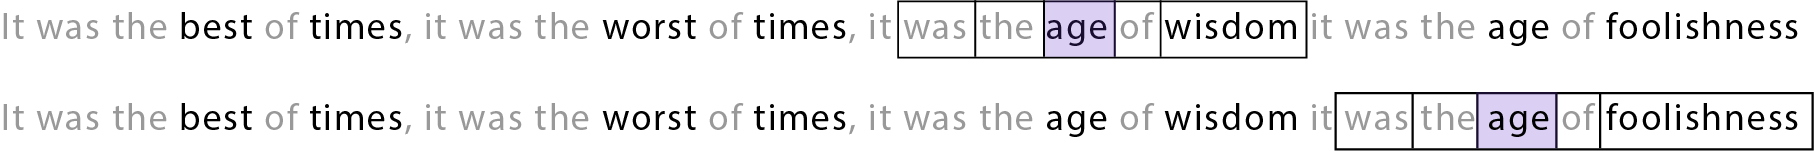

In [17]:
from IPython.display import Image 
Image(filename="best-of-times.png")

In [18]:
# part b - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
stripes = {'age':['wisdom','foolishness'], # example
           'best':['times'], # YOU FILL IN THE REST
           'foolishness':['age'],
           'times': ['best', 'worst'],
           'wisdom':['age'],
           'worst':['times']}

In [19]:
# part c - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [20]:
# part c - FILL IN THE MISSING LINE so that this cell 1-hot encodes the co-occurrence matrix
for term, nbrs in stripes.items():
    for nbr in nbrs:
        #pass
        ############# YOUR CODE HERE #################
        if nbr in vocab:
            co_matrix[term][vocab.index(nbr)] = 1
        
        ############# (END) YOUR CODE #################
co_matrix

,age,best,foolishness,times,wisdom,worst
age,0,0,1,0,1,0
best,0,0,0,1,0,0
foolishness,1,0,0,0,0,0
times,0,1,0,0,0,1
wisdom,1,0,0,0,0,0
worst,0,0,0,1,0,0


In [21]:
# part d - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]
    
    # cosine similarity
    ############# YOUR CODE HERE #################
    #initialize as 1-D arrays to use numpy functions np.dot() and np.sum()
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    #implement cosine sim equation
    csim = np.dot(v1, v2)/(np.sum(np.dot(v1, v1))*np.sum(np.dot(v2,v2)))**0.5
    ############# (END) YOUR CODE #################    
    
    print(f"{term1}-{term2}: {csim}")

age-best: 0.0
age-foolishness: 0.0
age-times: 0.0
age-wisdom: 0.0
age-worst: 0.0
best-foolishness: 0.0
best-times: 0.0
best-wisdom: 0.0
best-worst: 1.0
foolishness-times: 0.0
foolishness-wisdom: 1.0
foolishness-worst: 0.0
times-wisdom: 0.0
times-worst: 0.0
wisdom-worst: 0.0


# Question 4: Pairs and Stripes at Scale

As you read in the paper by Zadeh et al, the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO implemetation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revist the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) short response:__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. Imagine for now that you have unlimited memory on each of your nodes and describe a sequence of map & reduce steps that would start from a raw corpus and reproduce your strategy from Q3. For each step be sure to note what information would be stored in memory on your nodes and what information would need to be shuffled over the network (a bulleted list of steps with 1-2 sentences each is sufficient to answer this question).

* __b) short response:__ In the asynch videos about "Pairs and Stripes" you were introduced to an alternative strategy. Explain two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __c) read provided code:__ The code below provides a streamined implementation of Document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __d) short response:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. Define each of these terms based on your reading of the provided code.

* __e) short response:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __f) short response:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations. Explain.

### Q4 Student Answers:
> __a)__ The following list is the series of maps and reduces that would have produced the strategy for Q3, given unlimited memory:
 - In the first mapper, we scan through each 5 consecutive word window in the corpus and creates pairs of all of the words that are not included in the list of stop words.  For instance, if all 5 words are not stop words, we should have 5 C 2 = 10 pairs.  In order to get all the pairs, we would need to commit each window of words to memory temporarily.  The mapper then emits each word pair with a count of 1 and also each reverse of the pair with a count of 1.  The reason that each pair and reverse pair is counted is because I would try to recreate the one-hot encoded matrix entries from Q3, which means that there is an entry for the words (A, B) and a separate entry for the words (B,A).  The keys from this mapper are the pairs and the values are the counts of 1
 - In the first reducer step, I would then sum all of the values for the same identical pair key.  The keys and their sums will be emitted from this reducer.  The reducers should essentially emit all of the entries of the one-hot encoded matrix we used in Q3. 
 - In a second mapper, I will transform each key-value pair from the first reducer.  The first word in the word pair key will become the new key. The value will then be a dictionary entry of the second word and the count of total occurrences of he pair.  So for each "(first word, second word)\tcount" row, the second mapper emits "first word \t{second word: count}"
 - the second reducer combines all key value pairs from the second mapper, such that all values with the same first word key will be combined into a larger dictionary.  The result that is emitted by the second reducer should be of the format "first word\t {second word 1: count 1, second word 2: count 2. second word 3: count 3, .....}".  Essentially the output from the second reducer should now have each keys that are the index values of the one-hot encoded matrix, and the values are dictionaries represent the rows, where each dictionary key is a column header and each dictionary value is the actual matrix entry.  Based on the previous steps, only non-zero values are included in the dictionary entries that re values. 
 - In a third mapper, I would take the outputs from the second reducer and append a total count to the values.  The output format would then be "first word\t[{second word 1: count 1, second word 2: count 2. second word 3: count 3, .....}, total count]", where total count is the number of dictionary entries or the set of unique second words that have co-corrence with the first word.  
 - At this point, we have all of the information we need to do the calculations for cosine similarity.  However, we will not be able to make all pair wise calculations, by pairs of the first word key, if the keys are passed to different nodes. Therefore, we would need to collect() all of our results from the previous steps into one RDD and cache() this result.
 - In a 4th mapper, we will need to create all possible pairs of the keys that were collected in the previous step. For n total keys, or n unique words in the corpus, we would have n(n-2)/2 pairs.  In this mapper, since we have unlimited memory on each node, we could output key-value pairs of the following format "(first word A, first word B)\t[dictionary A, dictionary B, total count A, total count B]", although this is not particularly efficient.
 - Then in the 4th reducer, we would perform all pairwise cosine similarity calculations.  Using the two dictionaries, we would sum all values pertaining to dictionary keys that appear in both dictionary A and dictionary B.  We then divide by the sum by the sqrt of total count A and total count B.  The 4th reducer would output these pairs and their cosine similarit results.

> __b)__ If we initially create stripes in a mapper, rather than pairs, we would have fewer key-value pairs to communicate between mapper and reducer.  This will greatly decrease the amount of information that is shuffled and transfered over network because instead of shuffling numerous individual pairs and their counts, we are shuffling words and some of their co-occuring words in the form of a stripe.  In addition, we do not need to double count pairs (A, B) and (B, A) for one hot encoded entries, so we reduce the number of key-value pairs that are shuffled and transfered by several times.  Furthermore, we are reducing the number of mapper and reducer steps that are needed.  Basically in one mapper and reducer step, we are able to get every unique word as a key and the unique list of all co-occuring words for each word, and the counts of co-occurence.  This also reduces the time and amount of effort to get to get to the results that then allow the subsquently computation the cosine similarities. 

> __c)__ _read provided code before answering d-f_ 

> __d)__ In the second mapper using splitWords(), the emitted key is a word in each document and emitted value is a tuple where the first tuple value is the document that the word appears in and the second tuple value is the number of words in that document.  The "posting" is esentially the tuple of the document ID and the word count within that document, for the document associated with the word key.  The word is an "inverted index" because this mapper essentially applies an inversion to its input.  The inputs to the mapper use the document ID as the key, and the words as the value.  However, the output of the mapper use the individual words as the key and the document IDs are now incorporated into the values.  The splitWords() mapper essentially performs a matrix inversion in which the row index from the input matrix has become the values in the output matrix and the values from the input matrix has become the row indexes in the output matrix.

> __e)__ The third mapper, makeCompositeKey(), makes pairs of all of the values within the list of postings that are associated with each word.  At this point, when we use this mapper, we have already performed a reducing step where we have each unique word in all documents as the key and the values are all of the tuples where the first value is the document that the word appears in and the second value is the size of the document.  In this mapper, we create all possible pairs of postings, and form a composite key of two tuples, then emit the value of 1 for each composite key.  It makes sense to synchronize around this information, which is all possible pairs of documents, because this is the only way to perform similarity metrics between documents.  If we did not create composite keys in this way, we would have needed to commit all of the documents to memory in order to make all possible pairwise calculations, which is very costly.  This transformation allows us to only count document pairs that truly share 1 or more words. In order to compute a metric like Jaccard or Cosine similarity, we are still missing the total dot product, or the total number of unique words that appear in each document pair.  That is why there is an additional reduce step to get this total.

> __f)__ The narrow spark transformations are the inputs to the 3 flatMap() functions which can take place within the individual partitions.  The wide spark transformations are the 2 reduceByKey() functions which require shuffling and aggregation of results from different nodes. 

A small test file: __`sample_docs.txt`__

In [22]:
%%writefile sample_docs.txt
docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly

Overwriting sample_docs.txt


__Document Similarity Analysis in Spark:__

In [23]:
# load data - RUN THIS CELL AS IS
data = sc.textFile("sample_docs.txt")  

In [24]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [25]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [26]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

**\*\*\*Following is my scratch work to help with interpretation of the Spark Job\*\*\***

In [27]:
data.map(lambda line: line.split('\t')).collect()

[['docA', 'bright blue butterfly forget'],
 ['docB', 'best forget bright sky'],
 ['docC', 'blue sky bright sun'],
 ['docD', 'under butterfly sky hangs'],
 ['docE', 'forget blue butterfly']]

In [28]:
data.map(lambda line: line.split('\t')).flatMap(splitWords).collect()

[('bright', [('docA', 4)]),
 ('blue', [('docA', 4)]),
 ('butterfly', [('docA', 4)]),
 ('forget', [('docA', 4)]),
 ('best', [('docB', 4)]),
 ('forget', [('docB', 4)]),
 ('bright', [('docB', 4)]),
 ('sky', [('docB', 4)]),
 ('blue', [('docC', 4)]),
 ('sky', [('docC', 4)]),
 ('bright', [('docC', 4)]),
 ('sun', [('docC', 4)]),
 ('under', [('docD', 4)]),
 ('butterfly', [('docD', 4)]),
 ('sky', [('docD', 4)]),
 ('hangs', [('docD', 4)]),
 ('forget', [('docE', 3)]),
 ('blue', [('docE', 3)]),
 ('butterfly', [('docE', 3)])]

In [29]:
data.map(lambda line: line.split('\t')).flatMap(splitWords).reduceByKey(lambda x,y : x+y).collect()

[('bright', [('docA', 4), ('docB', 4), ('docC', 4)]),
 ('butterfly', [('docA', 4), ('docD', 4), ('docE', 3)]),
 ('best', [('docB', 4)]),
 ('sky', [('docB', 4), ('docC', 4), ('docD', 4)]),
 ('sun', [('docC', 4)]),
 ('blue', [('docA', 4), ('docC', 4), ('docE', 3)]),
 ('forget', [('docA', 4), ('docB', 4), ('docE', 3)]),
 ('under', [('docD', 4)]),
 ('hangs', [('docD', 4)])]

In [30]:
data.map(lambda line: line.split('\t')).flatMap(splitWords).reduceByKey(lambda x,y : x+y).flatMap(makeCompositeKey).collect()

[("(('docA', 4), ('docB', 4))", 1),
 ("(('docA', 4), ('docC', 4))", 1),
 ("(('docB', 4), ('docC', 4))", 1),
 ("(('docA', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 1),
 ("(('docD', 4), ('docE', 3))", 1),
 ("(('docB', 4), ('docC', 4))", 1),
 ("(('docB', 4), ('docD', 4))", 1),
 ("(('docC', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docC', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 1),
 ("(('docC', 4), ('docE', 3))", 1),
 ("(('docA', 4), ('docB', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 1),
 ("(('docB', 4), ('docE', 3))", 1)]

In [31]:
data.map(lambda line: line.split('\t')).flatMap(splitWords).reduceByKey(lambda x,y : x+y)\
.flatMap(makeCompositeKey).reduceByKey(lambda x,y : x+y).collect()

[("(('docA', 4), ('docB', 4))", 2),
 ("(('docA', 4), ('docC', 4))", 2),
 ("(('docB', 4), ('docC', 4))", 2),
 ("(('docD', 4), ('docE', 3))", 1),
 ("(('docC', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docD', 4))", 1),
 ("(('docA', 4), ('docE', 3))", 3),
 ("(('docB', 4), ('docD', 4))", 1),
 ("(('docC', 4), ('docE', 3))", 1),
 ("(('docB', 4), ('docE', 3))", 1)]

In [32]:
data.map(lambda line: line.split('\t')).flatMap(splitWords).reduceByKey(lambda x,y : x+y)\
.flatMap(makeCompositeKey).reduceByKey(lambda x,y : x+y).flatMap(jaccard).collect()

[('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docB - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docA - docE', 0.75),
 ('docB - docD', 0.14285714285714285),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666)]

**\*\*\*Scratch work ends here\*\*\***

In [33]:
# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
result

[('docA - docE', 0.75),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docB - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

# About the Data
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: Synonym Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which in any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available on dropbox at: https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea
... below we provide the code to download these files. Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms. 

In [28]:
!mkdir data

In [29]:
# download the zipped data folder - RUN THIS CELL AS IS
!curl -L -o ngrams.zip https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  829M    0  829M    0     0   544k      0 --:--:--  0:25:59 --:--:--  851k


In [30]:
# unzip the data files into the data directory - RUN THIS CELL AS IS
!unzip -q ngrams.zip -d data

mapname:  conversion of  failed


In [6]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS = PWD + '/data'
F1_PATH = PWD + '/data/googlebooks-eng-all-5gram-20090715-0-filtered.txt'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [7]:
%%writefile systems_test.txt
it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1

Overwriting systems_test.txt


Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [8]:
# Spark RDDs for each dataset
testRDD = sc.textFile("systems_test.txt") 
f1RDD = sc.textFile(F1_PATH)
dataRDD = sc.textFile(NGRAMS)

Let's take a peak at what each of these RDDs looks like:

In [37]:
testRDD.take(10)

['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 'it was the worst of\t1\t1\t1',
 'of times it was the\t2\t1\t1',
 'of wisdom it was the\t1\t1\t1',
 'the age of wisdom it\t1\t1\t1',
 'the best of times it\t1\t1\t1',
 'the worst of times it\t1\t1\t1']

In [38]:
f1RDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

In [39]:
dataRDD.take(10)

['A CATALOGUE OF THE PATHOLOGICAL\t90\t90\t86',
 'A CT scan shows a\t208\t204\t123',
 'A Case of Frustrated Take\t94\t94\t77',
 'A Catalogue of Books and\t272\t270\t239',
 'A Celebration of the First\t129\t117\t89',
 'A Century of Failed School\t401\t400\t257',
 'A Christian Church is a\t46\t46\t46',
 "A Citizen's Right to Know\t71\t69\t57",
 'A Clinical Study of Treatment\t43\t43\t40',
 'A Commentary on the Epistle\t2870\t2645\t1475']

# Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) code:__ Write a Spark job to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurances of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._


* __b) short response:__ Given the vocab size you found in part a, how many potential synonym pairs could we form from this corpus? If each term's stripe were 1000 words long, how many individual 'postings' tuples would we need to shuffle inorder to form the inverted indices? Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __c) short response:__ What do you notice about the most frequent words, how usefull will these top words be in synonym detection? Explain.

* __d) short response:__ What do you notice/infer about the least frequent words, how reliable should we expect the detected 'synonyms' for the bottom words to be? Explain.

### Q5 Student Answers:

> __b)__ Given the vocab size of 269339, the number of potential synonym pairs is 269339x269338/2 = 36271613791 pairs. In the algorithm Q4, one tuple was created for each word in the strip to form the inverted indice.  For each word that is the key, we would have 1000 tuples corresponding to the pair of word key and a count of 1.  Given that the vocab size of 269339, we would need to shuffle a total of 2693390 individual tuples, which is a lot less than the number of pairs.

> __c)__ The most frequent words are common words that are not useful in synonym detection.  Most of these words are words that appear in a large number of sentences and thus do not contribute to the meaning of vocabulary words.  As we had done in #2, the removal of common words, which are also referred to as stop words, will help with similarity calculations that better match our expectations in interpretation of the text.  Therefore, the most common words should be labeled as stop words so that they do not contribute tot he vocabulary space.    

> __d)__ The least frequent words all of a count of 40 and they appear to be extremely uncommon, either as very rarely used vocabulary in English or they are proper names of locations, people (example: schwetzingen).  Given their extremely low frequencies and the very high frequencies of stop words (most common words), I would expect detected synonyms for the bottom words to be very more unreliable the smaller the size n of n-gram used for each word's stripe.  If we are using only 5-grams for instance, the sparseness of the least frequent words would lead to similarity metrics that are close to 0, since the likelihood of finding these words in the same 5 word neighborhood of actual synonyms is rare, given their own rareness.  If we increase n to much larger, we may be increase the likelihood fo finding synonyms in the same neighborhood, thereby increasing the similarity metrics and makes the detection more reliable. 

In [40]:
# part a - write your spark job here 
def parse(doc):
    '''helper function to parse documents and return word counts'''
    
    #parse row
    ngram, ngram_count, pages_count, books_count =  doc.lower().split('\t')
    #parse ngram
    words = ngram.split(' ')
    #the count returned for each word is actually the ngram count, or 1*ngram count
    return ([(word, int(ngram_count)) for word in words])

    

def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    ############# YOUR CODE HERE ###############
    
    unique_words = rdd.flatMap(parse) \
             .reduceByKey(lambda x,y : x+y) \
             .cache()
    
    total = unique_words.count()
    top_n = unique_words.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = unique_words.takeOrdered(n, key=lambda x: x[1])
    
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n

In [41]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.9151229858398438 seconds


In [42]:
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness          1 |            the  17


In [43]:
# part a - run a single file (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 2.6642043590545654 seconds


In [44]:
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |         barnes  40
      in    7470912 |         arnall  40
       a    6926743 |     buonaparte  40
     and    6150529 |       puzzling  40
    that    4077421 |             hd  40
      is    4074864 |        corisca  40
      be    3720812 |       cristina  40
     was    2492074 |         durban  40


In [45]:
# part a - run full analysis (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 343.57852387428284 seconds


In [46]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |   schwetzingen  40
      of 3698583299 |           cras  40
      to 2227866570 |       parcival  40
      in 1421312776 |          porti  40
       a 1361123022 |    scribbler's  40
     and 1149577477 |      washermen  40
    that  802921147 |    viscerating  40
      is  758328796 |         mildes  40
      be  688707130 |      scholared  40
      as  492170314 |       jaworski  40


__Expected output:__  
_(bottom words might vary a little due to ties)._
<table>
<th>Top Words</th>
<th>Bottom Words</th>
<tr><td><pre>
the 5490815394
of 3698583299
to 2227866570
in 1421312776
a 1361123022
and 1149577477
that  802921147
is  758328796
be  688707130
as  492170314
</pre></td>
<td><pre>
foretastes  40
parcival  40
schwetzingen  40
cras  40
 scholared  40
scribbler's  40
washermen  40
viscerating  40
unmurmuring  40
mildes  40
</pre></td></tr>
</table>

# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) code:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts  
  __`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers.


* __b) short response:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) code + short response:__ Write a Spark Job to compare the top/bottom words from Q5 and from part a. Specifically, what % of the 1000 most/least neighbors words also appear in the list of 1000 most/least frequent words. [__`NOTE:`__ _technically these lists are short enough to comparing in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

### Q6 Student Answers:

> __b)__ In the sample of 27010, it looks like the majority of words, as many as 24000, have 100 neighbors or less. There are a few hundred words with up to 1000 neighbors.  The number words with more than 1000 neighbors appear neglible with the sample of 27010.  In terms of our analysis with synonym detection, this will help us determine the feature space.  Since similarity metrics are determined by neighboring word overlaps between two words, our intution at first is to analyze as many neighbors as we collect.  However allowing an extremely large feature space where we allow the collection of unlimited neighbors may lead to exponentially higher complexity without better gains.  Given that the number of words with more than 1000 neighbors is negligible, perhaps it may make sense to limit the feature vectors to have length of 1000, allowing us to have a more efficient analysis.

> __c)__ 88% of the list of 1000 words with the most neighbors also appear in the list 1000 most frequent words. 1.9% of the 1000 words with the least neighbors appear in the list of 1000 least frequent words.  

In [14]:
def parse2(doc):
    '''helper function to parse documents and return unique neighbors in the n-gram as a set'''
    
    #parse row
    ngram, ngram_count, pages_count, books_count =  doc.lower().split('\t')
    #parse ngram
    words = ngram.split(' ')
    #for each word, we return all of the unique words in the n-gram
    #wedo not emit a key-value pair for words with 0 neighbors
    return ([(word, set(words)-set([word])) for word in words if len(set(words)) > 1])

    
def set_update(set_x, set_y):
    '''ensures that the union of two sets is properly returned
    - set_x.update(set_y) returns only None rather than the resulting set
    - function returns the actual union, which set_x'''
    set_x.update(set_y)
    return set_x

# part a - spark job
def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############
    
    unique_words_nbrs = rdd.flatMap(parse2) \
             .reduceByKey(lambda x,y : set_update(x,y)) \
             .map(lambda x: (x[0], len(x[1]))) \
             .cache()
    
    top_n = unique_words_nbrs.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = unique_words_nbrs.takeOrdered(n, key=lambda x: x[1])
    sampled_counts = unique_words_nbrs.sample(withReplacement = False, fraction=0.1).map(lambda x: x[1]).collect()

    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [48]:
# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.591031551361084 seconds


In [49]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9


In [50]:
# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 5.414033651351929 seconds


In [51]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |           pizza    2
         and    16489 |      noncleaved    2
          to    14249 |        premiers    2
          in    13891 |        enclaves    2
           a    13045 |   selectiveness    2
        that     8011 |           trill    2
          is     7947 |             gem    2
        with     7552 |            hoot    2
          by     7400 |     palpitation    2


In [52]:
# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 785.657482624054 seconds


In [53]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1


__Part a expected output:__  
_(bottom words might vary a little due to ties)._
<table>
<th>Most Neighbors</th>
<th>Least Neighbors</th>
<tr><td><pre>
the   164982 
of   155708 
and   132814 
in   110615 
to    94358 
a    89197
by    67266
with    65127
that    61174
as    60652
</pre></td>
<td><pre>
cococo    1
inin    1
charuhas    1
ooooooo    1
iiiii    1
iiiiii    1
cnj    1
choh    1
neg    1
cococococo    1
</pre></td></tr>
</table>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

NOTE: we'll exclude the 84 words with more than 6000 nbrs in this 26720 count sample.


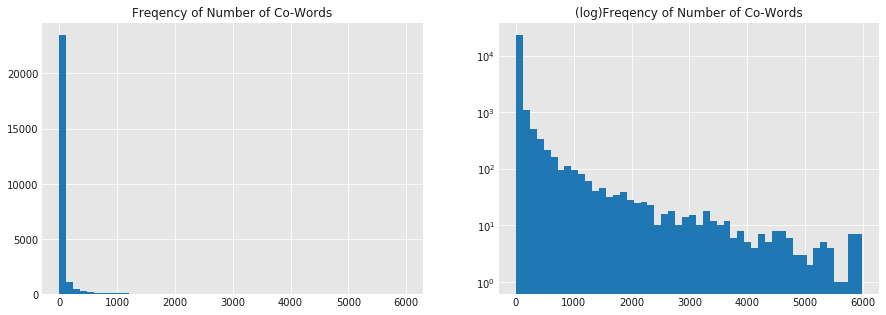

In [54]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)

# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')

plt.show()

In [57]:
# part c - spark job
def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############
    
    percent_overlap = rdd1.keys().intersection(rdd2.keys()).count()/rdd1.count()*100
    
    ############# (END) YOUR CODE ##############
    return percent_overlap

In [58]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(testRDD, 5)
topNbrs, bottomNbrs, sample_counts = EDA2(testRDD, 5)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 80.0 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 100.0 percent are also in the list of 1000 least frequent words.


In [59]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# for f1RDD 
total, topWords, bottomWords = EDA1(f1RDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(f1RDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 87.7 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 5.2 percent are also in the list of 1000 least frequent words.


In [60]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# for dataRDD
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 88.0 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 1.9 percent are also in the list of 1000 least frequent words.


# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary' (i.e. feature set). Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a) short response:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?

* __b) short response:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary (feature set), what alternative strategy could we take?

* __c) code:__ Write a spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  
  
  __NOTE:__ _to ensure consistency in results please use only the provided list of stopwords._  
  __NOTE:__ _as always, be sure to test your code on small files as you develop it._  

* __d) code:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, should return an RDD (which we will then use in q8).

### Q7 Student Answers:
> __a)__ The 1000 most frequent words would be a poor basis.  As we have seen with freqent words included in analysis with number 4, frequent words do not contribute much to the meaning of their neighbors.  Given their prevalence, they end up being neighbors of many other words.  Thus training with a basis of the 1000 most frequent words would lead to underfitting, a model that cannot capture word meanings correctly because the features vectors are not a good representation of the data needed to calculate similarities reliably.  This is characterized as underfitting because the data trends are not captured by the model and the prediction quality is poor.  Using the 1000 least frequent words would also be a poor basis.  The 1000 least frequent words are extremely sparce and likely do not exist as the neighbors of most words in the corpus. For most words we analysis, the features vectors constructed from a basis of 1000 least frequent words would be mostly 0's.  This leads us to build a model with very few data points that then cannot generalize well to new data sets, which would lead to overfitting.

> __b)__ In the event of an extremely large corpus, getting am estimate for freqencies can be done through sampling followed by extrapolation.  We can take multiple smaller samples from the corpus and perform word counts on these samples and perhaps apply some sort of averaging calculations at the end.  Taking mutilple samples will also allow us to see which words, if any, lead to wildly different counts across samples. For extrapolation, we can then perform a transformation to all counts where we multiply them by factor that is equal to the size of the corpus divided by the sample size.  This averaging a d extrapolation can only be done if we find that sample freqencies for the same words do not vary greatly across samples. Otherwise, more complicated weighted averaging will need to be performed. 

In [9]:
# part c - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [10]:
# part a - write your spark job here 
def parse_words(doc, stopwords):
    '''helper function to parse documents and return a partial word count
    words in the list of stopwords are excluded'''
    
    #parse row
    ngram, ngram_count, pages_count, books_count =  doc.lower().split('\t')
    words = ngram.split(' ')
    #return words and count = 1*n_gram_count but exclude stopwords
    return[(w, int(ngram_count)) for w in words if w not in stopwords]

# part c - spark job
def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None
    ############# YOUR CODE HERE ###############
    stopwords = sc.broadcast(set(STOPWORDS))
    
    vocab = rdd.flatMap(lambda x: parse_words(x, stopwords.value)) \
               .reduceByKey(lambda x,y : x+y) \
               .sortBy(lambda x: x[1], ascending = False) \
               .keys() \
               .take(n_total) 
    

    basis = vocab[-n_basis:]
    
    ############# (END) YOUR CODE ##############
    return vocab, basis

In [63]:
# part c - run your job (replace 'testRDD' with 'f1RDD'/'dataRDD' when ready)
VOCAB, BASIS = get_vocab(f1RDD, 10000, 1000)

In [64]:
# part c - save to file (RUN THIS CELL AS IS)
with open("vocabulary_f1RDD.txt", "w") as file:
    file.write(str(VOCAB))
with open("basis_f1RDD.txt", "w") as file:
    file.write(str(BASIS))

In [11]:
# part c - for dataRDD
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)
with open("vocabulary.txt", "w") as file:
    file.write(str(VOCAB))
with open("basis.txt", "w") as file:
    file.write(str(BASIS))

In [12]:
# part d - spark job

def set_intersection_update(set_x,set_y):
    '''ensures that the intersection of two sets is properly returned
    - set_x.intersection_update(set_y) returns only None rather than the resulting set
    - function returns the actual intersection, which set_x'''
    
    set_x.intersection_update(set_y)
    return set_x

def parse_words_vocab(doc, vocab):
    '''helper function parses documents and returns a unique words in each ngram
    only words in the vocabulary are included'''
    #parse row
    ngram, ngram_count, pages_count, books_count =  doc.lower().split('\t')
    #parse ngram and turn to set
    words = set(ngram.split(' '))
    return set_intersection_update(words, vocab)

def stripes(words):
    '''helper function that takes a set of n-gram words
    produces a partial stripe of unique neighbors
    only words in basis are included'''
    return [(word, words-set([word])) for word in words if len(words) > 0]
    

def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############
    
    vocab = sc.broadcast(set(vocab))
    basis = sc.broadcast(set(basis))
    

    stripesRDD = rdd.map(lambda x: parse_words_vocab(x, vocab.value)) \
                    .flatMap(stripes) \
                    .map(lambda x: (x[0], set_intersection_update(x[1], basis.value)))\
                    .filter(lambda x: len(x[1]) > 0) \
                    .reduceByKey(lambda x,y : set_update(x,y)) \
                    .cache()
    ############# (END) YOUR CODE ##############
    return stripesRDD
                         

In [15]:
# part d - run your systems test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
testStripesRDD.top(10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.29831600189208984 seconds


In [16]:
testStripesRDD.top(10)

[('worst', {'times'}),
 ('wisdom', {'age'}),
 ('times', {'age', 'best', 'worst'}),
 ('foolishness', {'age'}),
 ('best', {'times'}),
 ('age', {'foolishness', 'times', 'wisdom'})]

In [17]:
# part d - run your single file test (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS)
f1StripesRDD.top(5)
start = time.time()
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 6.4849853515625e-05 seconds


In [18]:
f1StripesRDD.top(5)

[('zenith', {'meridian'}),
 ('youth', {'affiliated', 'frustrated', 'illusions', 'mould'}),
 ('younger', {'careers'}),
 ('young', {'bees', 'hay', 'pink', 'scrap', 'undergoing', 'warrior', 'wax'}),
 ('york', {'designer', 'fifties', 'norway', 'tribune'})]

In [19]:
# part d - run the full analysis (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

In [20]:
# part d - take a look at a few stripes (RUN THIS CELL AS IS)
start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))

zones
['adhesion', 'warmer', 'environments', 'buffer', 'gaza', 'subdivided', 'parks', 'residential', 'uppermost', 'remotest', 'localities', 'saturation']
-------
zone
['diffuse', 'trigger', 'americas', 'poorly', 'persia', 'subdivided', 'tribal', 'auxiliary', 'unusually', 'alaska', 'sandy', 'saturation', 'vomiting', 'flexor', 'parked', 'intervening', 'cartilage', 'inorganic', 'uppermost', 'masculine', 'avoidance', 'cracks', 'guides', 'ie', 'traversed', 'au', 'originate', 'accumulate', 'southeastern', 'illuminated', 'assisting', 'articular', 'atlas', 'turbulent', 'narrower', 'penis', 'buffer', 'glowing', 'defines', 'penetrating', 'officially', 'residential', 'fibrous', 'transitional', 'contamination', 'excitation']
-------
zinc
['dysfunction', 'burns', 'pancreas', 'hydroxide', 'insoluble', 'weighing', 'wasting', "alzheimer's", 'transcription', 'diamond', 'leukemia', 'dietary', 'phosphorus', 'coating', 'dipped', 'radioactive', 'metallic', 'ammonium']
-------
Wall time: 371.35845041275024 

In [79]:
# part d - save your full stripes to file for ease of retrival later... (OPTIONAL)
stripesRDD.saveAsTextFile(PWD + '/stripes')

# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

### Q8 Tasks:
* __a) short response:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. What is the 'feature space' for this representation? (i.e. what are the features of our 1-hot encoded vectors?). What is the maximum length of a stripe?

* __b) short response:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.' How many rows will there be in our inverted index? Explain.

* __c) short response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index? (__`HINT:`__ _see your answer to Q4a & Q4b_)

* __d) code:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` (_remember stripe = document_)
  * aggregates the postings to create an inverted index
  * loops over all pairs of `term`s that appear in the same inverted index and emits co-occurrence counts
  * aggregates co-occurrences
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also returned the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._
  
* __e) code:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

### Q8 Student Answers:
> __a)__ The feature space for this representation is the 1000 words that are in the basis.  To calculate similarity of words in our vocabulary, we are taking into consideration of neighboring words of each vocabulary term only if the neighbor is in the 1000 basis.  Therefore, the basis constitutes the feature space and each features vector, if we use one-hot encoded notation would have 1000 elements where a 1 indicates that a word from the basis is a neighbor of the term and 0 indicates the basis word is not.  In our dense representation, the stripes only contain the basis words for which the one-hot encoded vector entry is 1.  Given that the limit of the basis is 1000 words, and we only collect unique neighbors in each stripe, the maximum length of any stripe is 1000.

> __b)__ The inverted index is created by to have the basis term as the key and a list of vocabulary words and stripe length tuples as the value.  This is inverted from the input, which has vocabulary words as the key and the basis terms as the values in the stripes.  When the inverted index is first created, there is one row for each occurence of a basis word as a stripe.  So the number of rows is the stripe length of every vocabulary word, summed over all 10000 vocabulary words.  After a reduce by key is performed on the inverted index, where all of the postings with the same basis term are collected, the number of rows of the inverted index is at most 1000, and would equal 1000 if every word in the feature space appeard as a neighbor at least one time. 

> __c)__ In question 2, we didn't use inverted index because we committed the entire one-hot encoded matrix to memory, and then we compared all possible combinations of terms.  We need the inverted index for this question because we do not have unlimited memory or unlimited resources to shuffle our data.  As a corpus gets larger, storing our entire vocabulary words and stripes data onto disk is very costly and maybe not possible.  In addition, comparing all word pairs will require 10000x9999/2 = 49995000 comparisons. With inverted index, we are able to generate all possible pairs of vocabulary words from the stripes data without incurring too much resources, since we only commit each strip to memory temporarily to generate the composite keys of pairs.  Furthermore, we creating much fewer comparisons rows with inverted syntax, since prior to reducing the inverted index will have most 1000x10000=10000000 rows, which is still 1/5 the number of rows as if we had not used inverted index.  In actual practice, the inverted index method produces much fewer rows and therefore less data for shuffling than 10000 since most words have 100 neighbors or less and very few words actually have 1000 neighbors. 

> __e)__ The most similar words have really high similarity scores, but many of the pairs are actually not synonyms.  Also the same words appear in many of the pairs, in particular, time, well, first and made. The pairs that appear are less synonym but words that are likely to appear together in the same sentence.  Therefore I would say that while the metrics are close to one, they are not super reliable in terms of finding true synonyms. One of the things I would change about the analysis in order to improve the results is to choose a better set of 1000 words for the features space.  While I think that choosing 1000 words from the middle of the most frequent words rankings much better than choosing the first 1000 or the last 1000, I do question if pulling 1000 words ranked 9000-10000 is a bit too haphazard.  While it is not wise to use only words in the first 1000 as the feature space, there might be some words in the first 1000 that are quite powerful in contributing to meanings of their neighbors.  The same can be said for words in the last 1000.  We are also missing useful words that are ranked from 1000-9000 or words that are immediately past the 10,000 cutoff.  Therefore, if we wanted to create a better basis  for improved results, but limit to 1000 words, we may want to consider randomly retriving words from various freqency rankings.  However, the number of words we retrive from each freqency ranking may be different depending on how close we are to the extremes.  That is to say, we may want to retrive words in the following way - 10 from ranking 1-1000, 20 from ranking 1000-2000, .... , 100 from ranking 9000-10000. In this way, we ensure that we pick the most words for the basis from the middle of the frequency rankings but we also do not miss words that might still be able to contribute to the meaning of their neighbors. 

In [21]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for pair, scores in lines:
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```


In [22]:
# part d - write your spark job in the space provided

###Please note, to allow better accesbility for testing, I placed my helper functions outside of the similarityAnalysis() function
def splitStripe(pair):
    '''Takes each vocabulary word and splits the stripe words to create postings'''
    term, stripe = pair
    
    for w in stripe:
        yield (w, [(term,len(stripe))])
    
def compositeKeyGeneration(inverted_index):
    '''sweeps the postings (vocabulary term, stripe word count) to make all possible pairs'''
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)
    
def similarityCalculations(line):
    '''function that calculates all 4 metrics for each pair of terms'''
    (term1, n1), (term2, n2) = ast.literal_eval(line[0])
    
    total = int(line[1])
    
    n1 = int(n1)
    n2 = int(n2)
    
    cosine = total/float((n1*n2)**0.5)
    jaccard = total/float(n1 + n2 - total)
    overlap = total/float(min(n1, n2))
    dice = total/float((n1+n2)/2)
    
    yield term1+" - "+term2, (cosine, jaccard, overlap, dice)

def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############### YOUR CODE HERE ################
        
    #spark job starts here
    simScoresRDD = stripesRDD.flatMap(splitStripe) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(compositeKeyGeneration) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(similarityCalculations) \
             .cache()
    
    
    top_n = simScoresRDD.takeOrdered(n, key=lambda x: -x[1][0])
    bottom_n = simScoresRDD.takeOrdered(n, key=lambda x: x[1][0])

    ############### (END) YOUR CODE ##############
    return simScoresRDD, top_n, bottom_n

In [23]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.5792744159698486 seconds


In [24]:
print("MOST SIMILAR:")
displayOutput(top_n)
print("")
print("LEAST SIMILAR:")
displayOutput(bottom_n)

MOST SIMILAR:
Pair                     |Cosine, Jaccard, Overlap, Dice 
best - worst             |   1.0,     1.0,     1.0,   1.0
foolishness - wisdom     |   1.0,     1.0,     1.0,   1.0
times - wisdom           |0.5774,  0.3333,     1.0,   0.5
age - best               |0.5774,  0.3333,     1.0,   0.5
age - worst              |0.5774,  0.3333,     1.0,   0.5
foolishness - times      |0.5774,  0.3333,     1.0,   0.5

LEAST SIMILAR:
Pair                     |Cosine, Jaccard, Overlap, Dice 
times - wisdom           |0.5774,  0.3333,     1.0,   0.5
age - best               |0.5774,  0.3333,     1.0,   0.5
age - worst              |0.5774,  0.3333,     1.0,   0.5
foolishness - times      |0.5774,  0.3333,     1.0,   0.5
best - worst             |   1.0,     1.0,     1.0,   1.0
foolishness - wisdom     |   1.0,     1.0,     1.0,   1.0


In [25]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 1.1522917747497559 seconds


In [26]:
print("MOST SIMILAR:")
displayOutput(top_n)
print("")
print("LEAST SIMILAR:")
displayOutput(bottom_n)

MOST SIMILAR:
Pair                     |Cosine, Jaccard, Overlap, Dice 
dans - memorable         |   1.0,     1.0,     1.0,   1.0
names - novel            |   1.0,     1.0,     1.0,   1.0
names - twelfth          |   1.0,     1.0,     1.0,   1.0
novel - pulp             |   1.0,     1.0,     1.0,   1.0
novel - twelfth          |   1.0,     1.0,     1.0,   1.0
deadly - gas             |   1.0,     1.0,     1.0,   1.0
deadly - hatred          |   1.0,     1.0,     1.0,   1.0
deadly - installed       |   1.0,     1.0,     1.0,   1.0
gas - hatred             |   1.0,     1.0,     1.0,   1.0
hatred - poems           |   1.0,     1.0,     1.0,   1.0

LEAST SIMILAR:
Pair                     |Cosine, Jaccard, Overlap, Dice 
many - time              |0.0348,  0.0175,    0.04, 0.0345
form - time              |0.0348,  0.0175,    0.04, 0.0345
made - many              |0.0354,  0.0179,    0.04, 0.0351
time - upon              |0.0355,  0.0179,  0.0417, 0.0351
time - well              |0.0355,  0.0

In [27]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 1249.4658615589142 seconds


In [28]:
# part d - display the results (RUN THIS CELL AS IS)
print("MOST SIMILAR:")
displayOutput(top_n)
print("")
print("LEAST SIMILAR:")
displayOutput(bottom_n)

MOST SIMILAR:
Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,  

__Expected output:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair           |Cosine, Jaccard, Overlap, Dice 
first - time   |  0.89,  0.8012,  0.9149, 0.8897
time - well    |0.8895,   0.801,   0.892, 0.8895
great - time   | 0.875,  0.7757,   0.925, 0.8737
part - well    | 0.874,  0.7755,  0.9018, 0.8735
first - well   |0.8717,  0.7722,  0.8936, 0.8715
part - time    |0.8715,  0.7715,  0.9018, 0.871
time - upon    |0.8668,   0.763,  0.9152, 0.8656
made - time    | 0.866,  0.7619,  0.9109, 0.8649
made - well    |0.8601,  0.7531,  0.9022, 0.8592
time - way     |0.8587,  0.7487,  0.9259, 0.8563
great - well   |0.8526,  0.7412,  0.8988, 0.8514
time - two     |0.8517,  0.7389,  0.9094, 0.8498
first - great  |0.8497,  0.7381,  0.8738, 0.8493
first - part   |0.8471,  0.7348,  0.8527, 0.8471
great - upon   |0.8464,  0.7338,  0.8475, 0.8464
upon - well    |0.8444,   0.729,   0.889, 0.8433
new - time     |0.8426,   0.724,  0.9133, 0.8399
first - two    |0.8411,  0.7249,  0.8737, 0.8405
way - well     |0.8357,  0.7146,  0.8986, 0.8335
time - us      |0.8357,  0.7105,  0.9318, 0.8308
</pre></td>
<td><pre>
Pair                  |Cosine, Jaccard, Overlap, Dice 
region - write        |0.0067,  0.0032,  0.0085, 0.0065
relation - snow       |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took        |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor          |0.0076,   0.002,  0.0263, 0.004
came - tumor          |0.0076,   0.002,  0.0263, 0.004
let - therapy         |0.0076,   0.003,  0.0161, 0.0059
related - stay        |0.0078,  0.0036,  0.0116, 0.0072
factors - hear        |0.0078,  0.0039,  0.0094, 0.0077
implications - round  |0.0078,  0.0033,  0.0145, 0.0066
came - proteins       |0.0079,   0.002,  0.0286, 0.0041
population - window   |0.0079,  0.0039,    0.01, 0.0077
love - proportional   | 0.008,  0.0029,  0.0185, 0.0058
got - multiple        | 0.008,  0.0034,  0.0149, 0.0067
changes - fort        |0.0081,  0.0032,  0.0161, 0.0065
layer - wife          |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy       |0.0081,  0.0034,  0.0149, 0.0068
arrival - essential   |0.0081,   0.004,  0.0093, 0.008
desert - function     |0.0081,  0.0031,  0.0175, 0.0062
fundamental - stood   |0.0081,  0.0038,  0.0115, 0.0077
patients - plain      |0.0081,   0.004,  0.0103, 0.0079
</pre></td></tr>
</table>

### Congratulations, you've completed HW3! Please see the readme file for submission instructions.